<a href="https://colab.research.google.com/github/shvms/Suicide_pred/blob/master/SuicideIdeation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import re
import json
import csv
import numpy
from matplotlib import pyplot as plt
import numpy as np

In [0]:
# helper function
# to condense three or more repetitive letters into one
def condense(text, rep_size=3):
  """
  text: string data to filter
  rep_size: >= repetitive letters
  """
  return re.sub('(.)\\1{'+ str(rep_size-1) +',}', r'\1', text)

In [0]:
# helper function to plot graphs
def plot_graphs(history, metric):
  plt.plot(history.history[f'{metric}'])
  plt.plot(history.history[f'val_{metric}'])
  plt.xlabel('#Epochs')
  plt.ylabel(metric)
  plt.legend([metric, f'val_{metric}'])
  plt.show()

In [0]:
!pip install tensorflow===1.15.0

     |████████████████████████████████| 412.3MB 27kB/s 
     |████████████████████████████████| 512kB 45.3MB/s 
     |████████████████████████████████| 3.8MB 50.5MB/s 
  Found existing installation: tensorflow-estimator 2.0.1
    Uninstalling tensorflow-estimator-2.0.1:
      Successfully uninstalled tensorflow-estimator-2.0.1
  Found existing installation: tensorboard 2.0.2
    Uninstalling tensorboard-2.0.2:
      Successfully uninstalled tensorboard-2.0.2
  Found existing installation: tensorflow 2.0.0
    Uninstalling tensorflow-2.0.0:
      Successfully uninstalled tensorflow-2.0.0


In [0]:
from sklearn.metrics import classification_report
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
print(tf.__version__)

1.15.0


In [0]:
tf.compat.v1.disable_eager_execution()

In [0]:
with open('/tmp/stopwords.txt', 'r', encoding='utf-8') as file:
  stopwords = file.readlines()
stopwords = [line.strip() for line in stopwords]

In [0]:
print(f"Total stopwords: {len(stopwords)}")
print(stopwords[:20])

Total stopwords: 823
['x', 'y', 'your', 'yours', 'yourself', 'yourselves', 'you', 'yond', 'yonder', 'yon', 'ye', 'yet', 'z', 'zillion', 'j', 'u', 'umpteen', 'usually', 'us', 'username']


In [0]:
# hyperparameters
vocab_size = 1000
embedding_dim = 300
max_length = 150
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<oov>'
training_portion = .8

In [0]:
sentences, labels = list(), list()
with open('/tmp/finalcsv.csv', 'r', encoding='utf-8') as csvfile:
  reader = csv.DictReader(csvfile)
  for row in reader:
    sentences.append(row['posts/post'])
    labels.append(row['posts/intent'])

labels = list(map(int, labels))

print(f"Total dataset: {len(sentences)}")
print(f"Total suicidal intent posts: {sum(labels)}")
print(f"Total non-suicidal intent posts: {len(labels)-sum(labels)}")

Total dataset: 695
Total suicidal intent posts: 341
Total non-suicidal intent posts: 354


In [0]:
train_sentences, train_labels = list(), list()
test_sentences, test_labels = list(), list()

train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

test_sentences = sentences[train_size:]
test_labels = labels[train_size:]

# Remove Repeated Characters
Characters repeated thrice or more can be removed, like *dieeeee* becomes *die*.

In [0]:
train_sentences = [condense(sentence) for sentence in train_sentences]
test_sentences = [condense(sentence) for sentence in test_sentences]

# Final Text Preprocessing
### Removing special characters & digits along with mixed words

In [0]:
pat = r'([A-Za-z]+[\d@]+[\w@]*|[\d@]+[A-Za-z]+[\w@]*)'
train_sentences = [re.sub(pat, '', sentence) for sentence in train_sentences]             # removing words like he12eoo00
train_sentences = [re.sub(r'<!--?.*?-->', '', sentence) for sentence in train_sentences]  # removing html tags if available
train_sentences = [re.sub(r'[\W|\d]+', ' ', sentence) for sentence in train_sentences]   # removing 

# Preprocessing

In [0]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length,
  padding=padding_type, truncating=trunc_type)

In [0]:
with open('/tmp/word_index.json', 'w') as file:
  json.dump(word_index, file)

In [0]:
print(train_sequences[0])
print(len(train_sequences[0]))
print(train_padded_sequences[0])
print(len(train_padded_sequences[0]))
print(type(train_padded_sequences[0]))

[2, 184, 1, 11, 452, 36, 76, 281, 68, 36, 19, 619, 2, 24, 197, 2, 184, 2, 24, 197, 7, 208, 50, 2, 24, 668, 19, 72, 23, 7, 1, 1, 60, 6, 1, 2, 54, 119, 46, 7, 342, 9, 7, 1, 17, 8, 75, 85, 46, 19, 83, 694, 240, 7, 91, 2, 24, 343, 2, 184, 64, 3, 299, 1, 13, 5, 832, 6, 93, 59, 883, 17, 2, 77, 52, 478, 1, 350, 11, 49, 2, 24, 78, 145, 35, 1, 8, 45]
88
[  2 184   1  11 452  36  76 281  68  36  19 619   2  24 197   2 184   2
  24 197   7 208  50   2  24 668  19  72  23   7   1   1  60   6   1   2
  54 119  46   7 342   9   7   1  17   8  75  85  46  19  83 694 240   7
  91   2  24 343   2 184  64   3 299   1  13   5 832   6  93  59 883  17
   2  77  52 478   1 350  11  49   2  24  78 145  35   1   8  45   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
150
<class 'numpy.ndarray'>


In [0]:
train_sentences[0]

'i cry everydayIs that normal Do more depressed people do this Whenever I m alone I cry I m alone a lot As i m writing this there s a tear rolling from my cheek I ve always been a bit of a crybaby but it has never been this much Multiple times a day I m crying I cry myself to sleep everynight In the beginning my family would notice but I think they stopped bothering Either that or I m really good at covering it up '

In [0]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length,
  padding=padding_type, truncating=trunc_type)

In [0]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# 1. Word2Vec Only Model

In [0]:
# hyperparameters
embedding_dim_1 = 300
dense1 = 24
dense2 = 1

In [0]:
# setting up
model1 = keras.models.Sequential([
  keras.layers.Embedding(vocab_size, embedding_dim_1, input_length=max_length),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(dense1, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])
model1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model1.summary())






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 300)          300000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                7224      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 307,249
Trainable params: 307,249
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# training
num_epochs = 10
history1 = model1.fit(train_padded_sequences, train_labels, epochs=num_epochs,
                    validation_data=(test_padded_sequences, test_labels))




Train on 556 samples, validate on 139 samples
Epoch 1/10





556/556 [==============================] - 4s 6ms/step - loss: 0.6752 - acc: 0.6385 - val_loss: 0.6763 - val_acc: 0.6763
Epoch 2/10
556/556 [==============================] - 0s 138us/step - loss: 0.6335 - acc: 0.7446 - val_loss: 0.6514 - val_acc: 0.6978
Epoch 3/10
556/556 [==============================] - 0s 143us/step - loss: 0.5866 - acc: 0.7716 - val_loss: 0.6147 - val_acc: 0.7410
Epoch 4/10
556/556 [==============================] - 0s 140us/step - loss: 0.5412 - acc: 0.7788 - val_loss: 0.5924 - val_acc: 0.7266
Epoch 5/10
556/556 [==============================] - 0s 147us/step - loss: 0.4950 - acc: 0.8129 - val_loss: 0.5453 - val_acc: 0.7554
Epoch 6/10
556/556 [==============================] - 0s 142us/step - loss: 0.4533 - acc: 0.8327 - val_loss: 0.5348 - val_acc: 0.7194
Epoch 7/10
556/556 [==============================] - 0s 129us/step - loss: 0.4174 - acc: 0.8507 - val_loss: 0.5113 - val_acc: 0.7410
Epoch 8/10

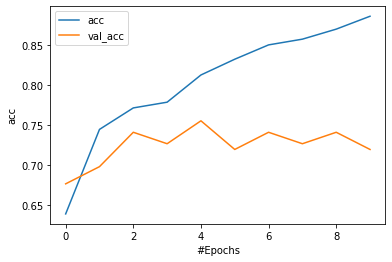

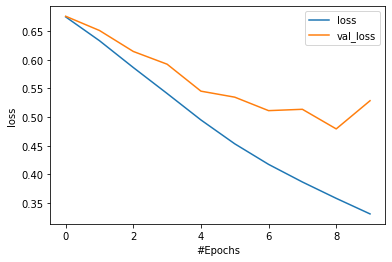

In [0]:
# Metrics analysis
plot_graphs(history1, 'acc')
plot_graphs(history1, 'loss')

# 2. LSTM

In [0]:
# hyperparametes
embedding_dim_2 = 64
memory_units = 64
dense_units = 32
dropout_rate = 0.2

In [0]:
class clbk(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('val_acc') >= 0.8):
      print("Achieved.")
      self.model.stop_training=True

In [0]:
model2 = keras.Sequential([
  keras.layers.Embedding(vocab_size, embedding_dim_2, input_length=max_length),
  keras.layers.LSTM(memory_units),
  keras.layers.Dense(dense_units, activation='relu'),
  keras.layers.Dropout(dropout_rate),
  keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 64)           64000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 99,137
Trainable params: 99,137
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# training
num_epochs = 30
history2 = model2.fit(train_padded_sequences, train_labels, epochs=num_epochs,
                    validation_data=(test_padded_sequences, test_labels), batch_size=64, callbacks=[clbk()])

Train on 556 samples, validate on 139 samples
Epoch 1/30
556/556 [==============================] - 3s 6ms/step - loss: 0.6905 - acc: 0.5162 - val_loss: 0.6943 - val_acc: 0.4748
Epoch 2/30
556/556 [==============================] - 3s 5ms/step - loss: 0.6816 - acc: 0.6277 - val_loss: 0.6991 - val_acc: 0.5468
Epoch 3/30
556/556 [==============================] - 3s 5ms/step - loss: 0.6696 - acc: 0.6331 - val_loss: 0.7079 - val_acc: 0.5683
Epoch 4/30
556/556 [==============================] - 3s 5ms/step - loss: 0.6531 - acc: 0.6655 - val_loss: 0.6904 - val_acc: 0.5683
Epoch 5/30
556/556 [==============================] - 3s 5ms/step - loss: 0.5960 - acc: 0.7014 - val_loss: 0.6616 - val_acc: 0.5971
Epoch 6/30
556/556 [==============================] - 3s 5ms/step - loss: 0.5707 - acc: 0.7464 - val_loss: 0.6655 - val_acc: 0.6259
Epoch 7/30
556/556 [==============================] - 3s 5ms/step - loss: 0.5158 - acc: 0.7500 - val_loss: 0.6095 - val_acc: 0.6475
Epoch 8/30
556/556 [==========

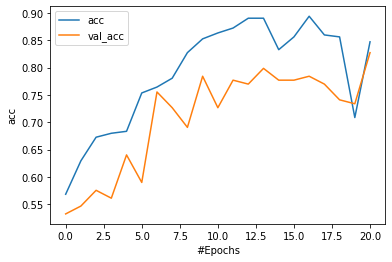

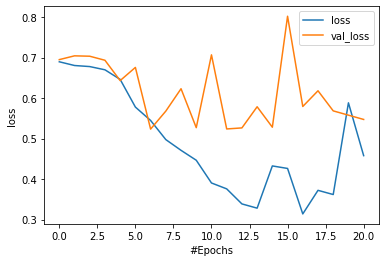

In [0]:
# Metrics analysis
plot_graphs(history2, 'acc')
plot_graphs(history2, 'loss')

# Saving model

In [0]:
import pickle

In [0]:
with open('lstm.model.json', 'w') as json_file:
  json_file.write(model2.to_json())

model2.save_weights('model.lstm.h5')
print('Saved model to disk')

Saved model to disk


In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model_file('/tmp/model.lstm.h5')
tfmodel = converter.convert()

ValueError: ignored

# C-LSTM

In [0]:
# hyperparameters
memory_units = 128
dense_units = 32
dropout_rate = 0.2

In [0]:
model3 = keras.models.Sequential([
  keras.layers.Conv1D(64, (5), activation='relu', input_shape=(max_length, 1)),
  keras.layers.MaxPooling1D(2),
  keras.layers.LSTM(int(memory_units/2)),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(1, activation='sigmoid')
])
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model3.summary())


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 116, 64)           384       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 58, 64)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 12,833
Trainable params: 12,833
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
print(train_padded_sequences.shape)
print(test_padded_sequences.shape)

(556, 120)
(139, 120)


In [0]:
train_padded_sequences_2 = train_padded_sequences.reshape(556, 120, 1)
test_padded_sequences_2 = test_padded_sequences.reshape(139, 120, 1)

In [0]:
# training
num_epochs = 30
history3 = model3.fit(train_padded_sequences_2, train_labels, epochs=num_epochs,
                    validation_data=(test_padded_sequences_2, test_labels), batch_size=64, callbacks=[clbk()])

Train on 556 samples, validate on 139 samples
Epoch 1/30
556/556 [==============================] - 8s 15ms/step - loss: 0.7487 - acc: 0.5719 - val_loss: 0.7383 - val_acc: 0.5180
Epoch 2/30
556/556 [==============================] - 1s 2ms/step - loss: 0.6817 - acc: 0.6169 - val_loss: 0.7376 - val_acc: 0.4964
Epoch 3/30
556/556 [==============================] - 1s 2ms/step - loss: 0.6783 - acc: 0.6223 - val_loss: 0.7239 - val_acc: 0.4820
Epoch 4/30
556/556 [==============================] - 1s 2ms/step - loss: 0.6660 - acc: 0.6115 - val_loss: 0.7161 - val_acc: 0.4676
Epoch 5/30
556/556 [==============================] - 1s 2ms/step - loss: 0.6417 - acc: 0.6277 - val_loss: 0.7199 - val_acc: 0.4748
Epoch 6/30
556/556 [==============================] - 1s 2ms/step - loss: 0.6464 - acc: 0.6313 - val_loss: 0.7158 - val_acc: 0.5252
Epoch 7/30
556/556 [==============================] - 1s 2ms/step - loss: 0.6358 - acc: 0.6295 - val_loss: 0.7302 - val_acc: 0.5180
Epoch 8/30
556/556 [=========

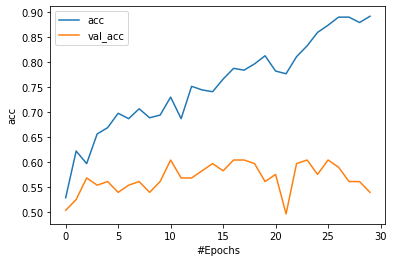

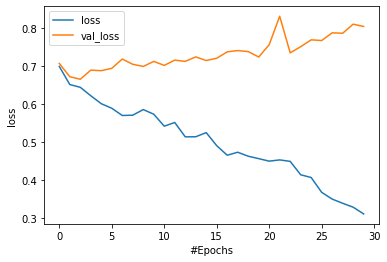

ValueError: ignored

In [0]:
# Metrics analysis
plot_graphs(history3, 'acc')
plot_graphs(history3, 'loss')

In [0]:
vocab_size = 1000
max_length2 = 150

train_sentences2 = [' '.join([word for word in sentence.split(' ') if word.strip() not in stopwords]) for sentence in train_sentences]
test_sentences2 = [' '.join([word for word in sentence.split(' ') if word.strip() not in stopwords]) for sentence in test_sentences]

tokenizer2 = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

tokenizer2.fit_on_texts(train_sentences2)
word_index = tokenizer2.word_index
print(len(word_index))

train_sequences2 = tokenizer.texts_to_sequences(train_sentences2)
train_padded_sequences2 = pad_sequences(train_sequences2, maxlen=max_length2,
  padding=padding_type, truncating=trunc_type)

7928


In [0]:
test_sequences2 = tokenizer.texts_to_sequences(test_sentences2)
test_padded_sequences2 = pad_sequences(test_sequences2, maxlen=max_length2,
  padding=padding_type, truncating=trunc_type)

In [0]:
# hyperparametes
embedding_dim_2 = 64
memory_units = 64
dense_units = 32
dropout_rate = 0.2

model4 = keras.Sequential([
  keras.layers.Embedding(vocab_size, embedding_dim_2, input_length=max_length2),
  keras.layers.Dropout(dropout_rate),
  keras.layers.LSTM(memory_units),
  keras.layers.Dropout(dropout_rate),
  keras.layers.Dense(dense_units, activation='relu'),
  keras.layers.Dropout(dropout_rate),
  keras.layers.Dense(1, activation='sigmoid')
])
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model4.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 150, 64)           64000     
_________________________________________________________________
dropout_6 (Dropout)          (None, 150, 64)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [0]:
# training
session=tf.Session()
with session.as_default():
    with session.graph.as_default():
      num_epochs = 30
      history4 = model4.fit(train_padded_sequences2, train_labels, epochs=num_epochs,
                    validation_data=(test_padded_sequences2, test_labels), batch_size=64, callbacks=[clbk()])

Train on 556 samples, validate on 139 samples
Epoch 1/30
556/556 [==============================] - 4s 7ms/step - loss: 0.6920 - acc: 0.5216 - val_loss: 0.6961 - val_acc: 0.4748
Epoch 2/30
556/556 [==============================] - 2s 4ms/step - loss: 0.6933 - acc: 0.5216 - val_loss: 0.6993 - val_acc: 0.4748
Epoch 3/30
556/556 [==============================] - 3s 6ms/step - loss: 0.6915 - acc: 0.5216 - val_loss: 0.6968 - val_acc: 0.4748
Epoch 4/30
556/556 [==============================] - 3s 5ms/step - loss: 0.6912 - acc: 0.5360 - val_loss: 0.6963 - val_acc: 0.4748
Epoch 5/30
556/556 [==============================] - 3s 5ms/step - loss: 0.6888 - acc: 0.5522 - val_loss: 0.6976 - val_acc: 0.4676
Epoch 6/30
556/556 [==============================] - 2s 4ms/step - loss: 0.6869 - acc: 0.5809 - val_loss: 0.6994 - val_acc: 0.4676
Epoch 7/30
556/556 [==============================] - 3s 5ms/step - loss: 0.6811 - acc: 0.6097 - val_loss: 0.7000 - val_acc: 0.4532
Epoch 8/30
556/556 [==========

In [0]:
# Metrics analysis
plot_graphs(history2, 'acc')
plot_graphs(history2, 'loss')

NameError: ignored